In [199]:
import pandas as pd
import numpy as np
from IPython.display import clear_output
import joblib

from sklearn.model_selection import train_test_split
from sklearn import metrics as met, preprocessing as pp
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
import matplotlib.pyplot as plt

Datasets

In [200]:
# Load the datasets
Order_items = pd.read_csv('../Datasets/Datasets_original/olist_order_items_dataset.csv')
Order_reviews = pd.read_csv('../Datasets/Datasets_original/olist_order_reviews_dataset.csv')
Orders = pd.read_csv('../Datasets/Datasets_original/olist_orders_dataset.csv')

In [201]:
# New column added: time to complete the delivery
Orders['Delivery_time'] = pd.to_datetime(Orders["order_approved_at"]) - pd.to_datetime(Orders['order_delivered_customer_date'])

# Transform data into days
Orders['Delivery_time'] = -(Orders['Delivery_time'].apply(lambda x: x.days + (x.seconds // 86400)))

In [202]:
# Joining the datasets
DF=Orders.merge(Order_reviews,on="order_id")
DF=DF.merge(Order_items,on="order_id")

In [203]:
DF.drop_duplicates(inplace=True);

In [204]:
# Adding a categorical feature to set if the review_score is 4 or 5
DF['good_review'] = (DF.review_score > 3)
DF['good_review'].astype(str).replace({False: 0, True: 1})
DF['good_review'] = DF['good_review'].astype(int)

In [205]:
DF = DF[['Delivery_time', 'good_review']]
DF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112372 entries, 0 to 112371
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Delivery_time  109997 non-null  float64
 1   good_review    112372 non-null  int32  
dtypes: float64(1), int32(1)
memory usage: 2.1 MB


In [206]:
DF.dropna(inplace=True)
DF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109997 entries, 0 to 112371
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Delivery_time  109997 non-null  float64
 1   good_review    109997 non-null  int32  
dtypes: float64(1), int32(1)
memory usage: 2.1 MB


In [207]:
DF.sample(1)

,Delivery_time,good_review
14317,5.0,1


Pipeline

In [208]:
# Split data to train the Model
X = DF.drop(columns=['good_review'])
y = DF['good_review']
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, y, test_size = 0.25, random_state=20)

In [209]:
# We instance different Pipelines to get the best model
Lin_Pipe = Pipeline([("scl", pp.StandardScaler()),
                    ("Lin", LinearRegression())])

LR_Pipe = Pipeline([("scl", pp.StandardScaler()),
                    ("LR", LogisticRegression(random_state=21))])

KNN_Pipe = Pipeline([("scl", pp.StandardScaler()),
                     ("KNN", KNeighborsClassifier())])

Tree_Pipe = Pipeline([("scl", pp.StandardScaler()),
                      ("Tree", DecisionTreeClassifier(random_state=21))])

RF_Pipe = Pipeline([("scl", pp.StandardScaler()),
                      ("RFor", RandomForestClassifier(random_state=21))])

In [210]:
# List and Dictionary for identification
pipelines = [Lin_Pipe, LR_Pipe, KNN_Pipe, Tree_Pipe, RF_Pipe]
pipe_dict = {0: "LinearRegression", 1: "LogisticRegression", 2: "KNeighborsClassifier", 3: "DecisionTreeClassifier", 4: 'RandomForestClassifier'}

In [211]:
# Training models
for cant, pipe in enumerate(pipelines, start=1):
    pipe.fit(X_Train,Y_Train)
    clear_output(wait=True)
    print(f'{cant} model/s trained!')

5 model/s trained!


In [212]:
# Compare results and pick best one
best_acc, best_clf, best_pipe = 0.0, 0, ''
for idx, val in enumerate(pipelines):
	score = val.score(X_Test, Y_Test)
	if score > best_acc:
		best_acc, best_pipe, best_clf = score, val, idx
	print(f'{pipe_dict[idx]} pipeline accuracy in test: {score}')
print(f'Model with best accuracy: {pipe_dict[best_clf]}')

LinearRegression pipeline accuracy in test: 0.07319377044101838
LogisticRegression pipeline accuracy in test: 0.7902181818181818
KNeighborsClassifier pipeline accuracy in test: 0.7857454545454545
DecisionTreeClassifier pipeline accuracy in test: 0.7906909090909091
RandomForestClassifier pipeline accuracy in test: 0.7906909090909091
Model with best accuracy: DecisionTreeClassifier


In [213]:
# Saving pipeline to a file
joblib.dump(best_pipe, 'ML_best_model/Best_model.pkl', compress=1)
print(f'Pipeline {pipe_dict[best_clf]} saved!')

Pipeline DecisionTreeClassifier saved!


In [214]:
# Model statistics
best_pipe = joblib.load('ML_best_model/Best_model.pkl')
best_pipe.fit(X_Train, Y_Train)
Y_pred = best_pipe.predict(X_Test)
print(met.classification_report(Y_Test, Y_pred))

              precision    recall  f1-score   support

           0       0.70      0.16      0.26      6346
           1       0.80      0.98      0.88     21154

    accuracy                           0.79     27500
   macro avg       0.75      0.57      0.57     27500
weighted avg       0.77      0.79      0.74     27500



array([[ 1024,  5322],
       [  434, 20720]], dtype=int64)

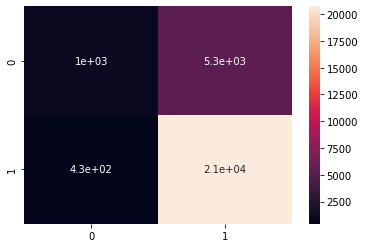

In [215]:
# Visualization
sns.heatmap(met.confusion_matrix(Y_Test, Y_pred),annot=True)
met.confusion_matrix(Y_Test, Y_pred)

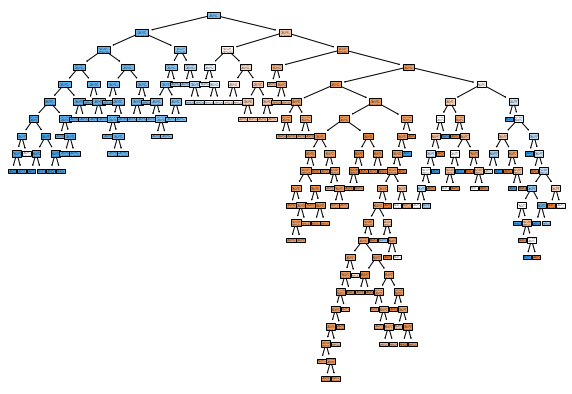

In [217]:
# Decision Tree
from sklearn import tree
plt.figure(figsize = (10,7))
tree.plot_tree(Tree_Pipe[1], filled = True)
plt.show()

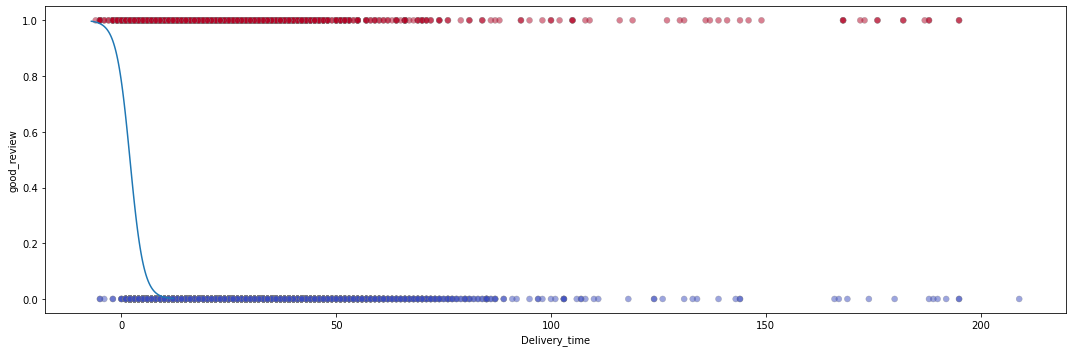

In [221]:
# Logistic Regression
from matplotlib import cm
def sigmoid_function(x,w0, w1):
   
    z = w0 + w1*x 
    y = 1/(1 + np.exp(-z))   
    return y

plt.figure(figsize = (15,5))
plt.scatter(X, y, c = y, alpha = 0.5, lw = 0.5, edgecolor = 'grey', cmap =cm.coolwarm)
x_plot = np.linspace(-7,12,100)
plt.plot(x_plot, sigmoid_function(x_plot,LR_Pipe[1].intercept_[0], LR_Pipe[1].coef_[0][0]))

plt.xlabel('Delivery_time')
plt.ylabel('good_review')
plt.tight_layout()

Prediction

In [236]:
Test = pd.DataFrame(np.arange(1,201,1))
Test.rename({0:'Delivery_time'},axis=1,inplace=True)

In [238]:
Test['prediction'] = best_pipe.predict(X)
Test.to_csv('../Datasets/Datasets_resultantes/Prediction.csv', index=False)
